In [48]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

In [4]:
def load_images_from_folder(folder, img_size=(512,512)):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = load_img(path, target_size=img_size)
        img = img_to_array(img) / 255.0  # normalizar
        images.append(img)
    return np.array(images)

In [5]:
def compute_ssim(y_true, y_pred):
    return ssim((y_true * 255).astype('uint8'), (y_pred * 255).astype('uint8'), channel_axis=2)

def psnr(img1, img2):
    return cv2.PSNR((img1 * 255).astype(np.uint8), (img2 * 255).astype(np.uint8))

In [33]:
results = []
n = 0

In [71]:
img_size = (256,256)
batch_size = 32
base_filters = 32
optimizer_class = Adam
lr = 1e-4
optimizer = optimizer_class(learning_rate=lr)
actFunc = 'sigmoid'

In [8]:
base_path = 'c:/Users/qdari/OneDrive/Documentos/aprendizajeSupervisado/planttraits2024'  ###
X = load_images_from_folder(os.path.join(base_path, 'images_original'), img_size = img_size)
Y = load_images_from_folder(os.path.join(base_path, 'images_clean'), img_size = img_size)
X_test = load_images_from_folder(os.path.join(base_path, 'images_test'), img_size = img_size)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(f'Train shape: {X_train.shape}, Validation shape: {X_val.shape}')


Train shape: (560, 256, 256, 3), Validation shape: (140, 256, 256, 3)


In [67]:
channels = (3,)
shape = img_size + channels

input_img = Input(shape=shape)  # Nueva entrada

# ===== Codificador =====
x = Conv2D(base_filters, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*2, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*16, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)

#x = Conv2D(base_filters*32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# ===== Decodificador =====
#x = Conv2D(base_filters*32, (3, 3), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*2, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Capa de salida
decoded = Conv2D(3, (3, 3), activation=actFunc, padding='same')(x)

# Modelo autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_144 (Conv2D)                  │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_65 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_145 (Conv2D)                  │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_146 (Conv2D)                  │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_147 (Conv2D)                  │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_148 (Conv2D)                  │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_149 (Conv2D)                  │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_65 (UpSampling2D)      │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_150 (Conv2D)                  │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_66 (UpSampling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_151 (Conv2D)                  │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_67 (UpSampling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_152 (Conv2D)                  │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_68 (UpSampling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_153 (Conv2D)                  │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_69 (UpSampling2D)      │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,496,451 (20.97 MB)

 Trainable params: 5,496,451 (20.97 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
channels = (3,)
shape = img_size + channels

input_img = Input(shape=shape)
x = Conv2D(base_filters, (3, 3), padding='same')(input_img)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*2, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*4, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), padding='same')(encoded)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*4, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*2, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), padding='same')(x)
decoded = LeakyReLU(negative_slope=0.01)(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer_class, loss='mse')
autoencoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_115 (Conv2D)                  │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_116 (Conv2D)                  │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_117 (Conv2D)                  │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_118 (Conv2D)                  │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_119 (Conv2D)                  │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_52 (UpSampling2D)      │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_120 (Conv2D)                  │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_53 (UpSampling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_121 (Conv2D)                  │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,461,251 (20.83 MB)

 Trainable params: 5,461,251 (20.83 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear generadores sincronizados para (X, Y)
train_generator = augmenter.flow(X_train, batch_size=batch_size)
target_generator = augmenter.flow(Y_train, batch_size=batch_size)

# Generador combinado: entrega pares (X_aug, Y_aug)
def combined_generator(gen1, gen2):
    while True:
        yield next(gen1), next(gen2)

augmented_data = combined_generator(train_generator, target_generator)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con imágenes aumentadas
autoencoder.fit(
    X_train, Y_train,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, Y_val),
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0864 - val_loss: 0.0850
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0886 - val_loss: 0.0850
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - loss: 0.0860 - val_loss: 0.0850
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0873 - val_loss: 0.0850
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0864 - val_loss: 0.0850
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0882 - val_loss: 0.0850
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - loss: 0.0911 - val_loss: 0.0850
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0896 - val_loss: 0.0850
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0878 - val_loss: 0.0850
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0857 - val_loss: 0.0850


In [73]:
#X_test = load_images_from_folder(os.path.join(base_path, 'images_test'), img_size = img_size)
X_denoised = autoencoder.predict(X_test)
##### Métricas
print("-"*10 + "Valores en prueba" + "-"*10 + "\n")

mse_test = [mean_squared_error(x_true.flatten(), x_pred.flatten())
              for x_true, x_pred in zip(X_test, X_denoised)]
print(f"MSE promedio: {np.mean(mse_test):.4f}")

ssim_test = np.mean([compute_ssim(y, yp) for y, yp in zip(X_test, X_denoised)])
print(f"SSIM promedio: {np.mean(ssim_test):.2f}")

psnr_test = np.mean([psnr(y, yp) for y, yp in zip(X_test, X_denoised)])
print(f"PSNR promedio: {np.mean(psnr_test):.2f} dB")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step
----------Valores en prueba----------

MSE promedio: 0.2324
SSIM promedio: 0.00
PSNR promedio: 6.62 dB


In [69]:
##### Métricas
X_denoised = autoencoder.predict(X_val)
print("-"*10 + " Valores en validación " + "-"*10 + "\n")

mse_val = [mean_squared_error(x_true.flatten(), x_pred.flatten())
              for x_true, x_pred in zip(X_val, X_denoised)]
print(f"MSE promedio: {np.mean(mse_val):.5f}")

ssim_val = np.mean([compute_ssim(y, yp) for y, yp in zip(X_val, X_denoised)])
print(f"SSIM promedio: {np.mean(ssim_val):.5f}")

psnr_val = np.mean([psnr(y, yp) for y, yp in zip(X_val, X_denoised)])
print(f"PSNR promedio: {np.mean(psnr_val):.5f} dB")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 425ms/step
----------Valores en prueba----------

MSE promedio: 0.2323
SSIM promedio: 0.00
PSNR promedio: 6.63 dB
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step
---------- Valores en validación ----------

MSE promedio: 0.21582
SSIM promedio: 0.00821
PSNR promedio: 7.05074 dB


In [62]:
results.append({
    'trial': n,
    'optimizer': optimizer_class,
    'learning_rate': lr,
    'batch_size': batch_size,
    'filters': base_filters,
    'actFunc' : "Leaky",
    'MSE_test': mse_test,
    'PSNR_test': psnr_test,
    'SSIM_test': ssim_test,
    'MSE_val': mse_val,
    'PSNR_val': psnr_val,
    'SSIM_val': ssim_val
})

n += 1

In [63]:
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='SSIM_test', ascending=False))

   trial optimizer  learning_rate  batch_size  filters actFunc  \
0      0      Adam        0.00010          16       64   Leaky   
1      1      Adam        0.00005          16       64   Leaky   
2      2      Adam        0.00005          16       64   Leaky   

                                            MSE_test  PSNR_test  SSIM_test  \
0  [0.20212947, 0.12137014, 0.10196792, 0.1829993...   9.240233   0.125554   
1  [0.19413434, 0.12085567, 0.1029101, 0.16420181...   9.218735   0.123991   
2  [0.24252526, 0.15865232, 0.13058077, 0.2150227...   8.108447   0.086698   

                                             MSE_val  PSNR_val  SSIM_val  
0  [0.106319614, 0.09252996, 0.10933158, 0.149725...  9.743910  0.173742  
1  [0.10667368, 0.090476625, 0.10799322, 0.151935...  9.672793  0.173500  
2  [0.14416893, 0.11270714, 0.1415386, 0.17888576...  8.560830  0.122058  


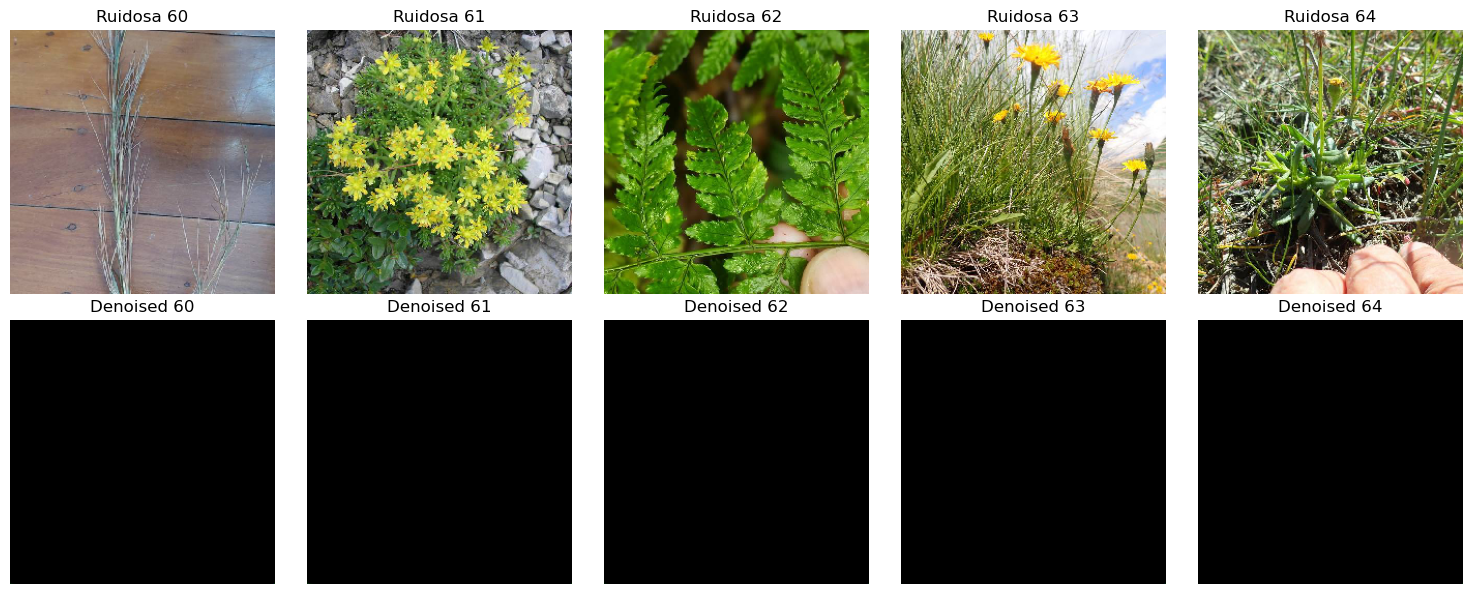

In [74]:
start_index = 60

# Mostrar comparativa: ruidosa vs reconstruida
n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    idx = start_index + i
    if idx >= len(X_test):
        break
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Ruidosa {idx}")
    plt.axis("off")
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_denoised[idx])
    plt.title(f"Denoised {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()